# Statistics and Figures for Analysis by Climate Zone

## Initialisation

In [1]:
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt

import initialise
import common
from analysis_utils import calc_statistics
from display_utils import display_frames

In [2]:
samples_file = os.path.join(common.DATASETS_DIR, 'samples_730days.csv')
model_dir = os.path.join(common.MODELS_DIR, 'evaluation_models', 'test3')

In [3]:
MODEL_RMSE = 27.52
MODEL_R2 = 0.47
TEXT_SIZE = 7
FONT_SIZE = 7
TITLE_SIZE = 8
MARKER_SIZE = 7
LINE_WIDTH = 0.75
SATURATION = 0.8

## Get the Samples and Predictions

In [4]:
with open(os.path.join(model_dir, 'model_params.json'), 'r') as f:
    ws_params = json.load(f)
all_samples = pd.read_csv(samples_file, index_col=0)
predicts = pd.read_csv(os.path.join(model_dir, f'ensemble{common.ENSEMBLE_SIZE}_{common.ANALYSIS_MODEL}.csv'), index_col=0)
samples = all_samples.reindex(predicts.index)

## Functions

### Statistical functions

In [5]:
def rmse(errors):
    return np.sqrt((errors ** 2).mean())

In [6]:
def gen_stats(y, yhat):
    data = pd.DataFrame({'y': y['LFMC value'], 'yhat': yhat, 'Climate Zone': y['Czone3']})
    data['Pred_error'] = data.yhat - data.y
    data['tss'] = (data.y - data.y.mean()) ** 2
    data['rss'] = (data.yhat - data.y) ** 2
    stats_ = data.groupby(['Climate Zone']).agg({'Pred_error': ['mean', rmse], 'tss': ['sum'], 'rss': ['sum']}).reset_index()
    stats_.columns = ['Climate Zone', 'mean', 'rmse', 'tss', 'rss']
    stats_['r2'] = 1 - stats_.rss / stats_.tss
    return stats_  

In [7]:
def gen_means(y, yhat):
    stats_ = pd.concat([gen_stats(y, p[1]) for p in yhat.items()])
    return stats_.groupby('Climate Zone').agg(
        bias=pd.NamedAgg(column='mean', aggfunc='mean'),
        bias_std=pd.NamedAgg(column='mean', aggfunc='std'),
        rmse=pd.NamedAgg(column='rmse', aggfunc='mean'),
        rmse_std=pd.NamedAgg(column='rmse', aggfunc='std'),
        r2=pd.NamedAgg(column='r2', aggfunc='mean'),
        r2_std=pd.NamedAgg(column='r2', aggfunc='std'),
    )

### Plotting functions

In [8]:
def get_whiskers(data, plot, group='Czone3'):
    whiskers = data.groupby([group])[plot].describe()[['25%', '75%']]
    whiskers['iqr'] = whiskers.diff(axis=1)['75%']
    whiskers['lower'] = whiskers['25%'] - 1.5 * whiskers['iqr']
    whiskers['upper'] = whiskers['75%'] + 1.5 * whiskers['iqr']
    return whiskers

In [9]:
def samples_plot(data, plot_order, czones, ax):
    data = data.sort_values(['count'])
    sns.barplot(y=data.Czone3, x=data['mean'], xerr=data['std'], palette=czones,
                saturation=SATURATION, error_kw=dict(lw=LINE_WIDTH), ax=ax, zorder=2)
    ax.set_ylabel('Climate Zone', fontsize=FONT_SIZE)
    ax.set_xlabel(f'Measured LFMC (%)', fontsize=FONT_SIZE)

    ypos = ax.get_yticks()
    for n, c in data.reset_index()['count'].items():
        ax.text(1, ypos[n], c, va='center', size=TEXT_SIZE, zorder=3)
    ax.text(1, -ypos[1] - 0.1, 'Samples', va='top', size=FONT_SIZE)

    ax.set_xlim((0, 200))
    ax.set_xticks(range(0, 250, 50))
    ax.tick_params(axis='y', labelsize=TEXT_SIZE)
    return ax

In [10]:
def samples_plot(data, samples, plot_order, czones, ax):
    data = data.sort_values(['count'])
    sns.boxplot(y='Czone3', x='LFMC value', data=samples, order=plot_order, palette=czones,
                saturation=SATURATION, width=0.7, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2, 'lw': LINE_WIDTH}, whiskerprops={'zorder': 2})
    ax.set_ylabel('Climate Zone', fontsize=FONT_SIZE)
    ax.set_xlabel(f'Measured LFMC (%)', fontsize=FONT_SIZE)

    whiskers = get_whiskers(samples, 'LFMC value').loc[data.Czone3]
    ypos = ax.get_yticks()
    for n, c in data.reset_index()['count'].items():
        va = 'center' if (data.iloc[n]['min'] > 35) or (whiskers.iloc[n]['lower'] > 35) else 'bottom'
        ax.text(2, ypos[n], c, va=va, size=TEXT_SIZE, zorder=3)
    ax.text(2, -ypos[1] - 0.1, 'Samples', va='top', size=FONT_SIZE)

    ax.set_xlim((0, 250))
    ax.set_xticks(range(0, 260, 50))
    ax.tick_params(labelsize=TEXT_SIZE)

    ylim = ax.get_ylim()
    xline = samples['LFMC value'].mean()
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=0.5, zorder=1)

    return ax, ylim

In [11]:
def results_plot(samples, predict, data, plot_order, czones, xlim, xline, ylim, ax):
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=0.75, zorder=1)

    bp_data = (predict.T - samples['LFMC value']).T
    bp_data['Czone3'] = samples['Czone3']
    bp_data = bp_data.set_index('Czone3').unstack().reset_index()
    bp_data.columns = ['Ensemble', 'Czone3', 'Error']

    whiskers = get_whiskers(bp_data, 'Error')
    
    sns.boxplot(y='Czone3', x='Error', data=bp_data, order=plot_order, palette=czones,
                saturation=SATURATION, width=0.7, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2, 'lw': LINE_WIDTH}, whiskerprops={'zorder': 2})
    for num, ytick in enumerate(ax2.get_yticks()):
        y_off = ytick
        rmse = data.set_index('Climate Zone').rmse.loc[plot_order[num]]
        bias_ = data.set_index('Climate Zone').bias.loc[plot_order[num]]
        pt, = ax.plot(rmse, y_off, 'dk', mfc=czones[num], mew=LINE_WIDTH, markersize=MARKER_SIZE, zorder=3)
        ax.text(rmse+3, y_off, round(rmse,2), va='bottom', ha='left', size=TEXT_SIZE)
        va = 'bottom' if whiskers.loc[plot_order[num]]['lower'] < -70 else 'center'
        t = ax.text(xlim[0]+1, y_off, round(bias_,2), va=va, ha='left', size=TEXT_SIZE)
    ax.set_ylabel(None)
    ax.set_xlabel(f'Estimation Error Distribution, RMSE and Bias (%)', fontsize=FONT_SIZE, fontname='Arial')
    ax.set_xlim(xlim)
    ax.set_xticks(range(int(xlim[0]/40)*40, xlim[1]+1, 40))
    ypos = ax.get_yticks()
    ax.text(xlim[0], -ypos[1] - 0.1, 'Bias (%)', va='top', size=FONT_SIZE)
    ax.tick_params(labelsize=TEXT_SIZE)
    return ax

In [17]:
def r2_plot(samples, predict, data, plot_order, czones, xlim, xlim_r2, xline, ylim, ax):
    xline_ = predicts.mean().mean()
    ax.plot([xline_, xline_], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=0.75, zorder=1)
    bp_data = predict.copy()
    bp_data['Czone3'] = samples['Czone3']
    bp_data = bp_data.set_index('Czone3').unstack().reset_index()
    bp_data.columns = ['Ensemble', 'Czone3', 'Estimation']

    sns.boxplot(y='Czone3', x='Estimation', data=bp_data, order=plot_order, palette=czones,
                saturation=SATURATION, width=0.7, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2, 'lw': LINE_WIDTH}, whiskerprops={'zorder': 2})

    whiskers = get_whiskers(bp_data, 'Estimation')

    ax1=ax.twiny()
    ax1.set_xlim(xlim_r2)
    ax1.set_xlabel("$R^2$", color="blue", fontsize=TEXT_SIZE)
    plt.setp(ax1.get_xticklabels(), color="blue", fontsize=TEXT_SIZE)
    ax1.plot([xline, xline], ylim, ':', color='blue', linewidth=LINE_WIDTH, alpha=0.75, zorder=-1)

    for num, ytick in enumerate(ax2.get_yticks()):
        y_idx = plot_order[num]
        r2 = data.set_index('Climate Zone').r2.loc[y_idx]
        pt, = ax1.plot(r2, ytick, '*k', mfc=czones[num], mec='blue', mew=LINE_WIDTH, markersize=MARKER_SIZE+2, zorder=3)
        x_off = -0.05 if num in [0, 3, 5] else 0.075 if r2 < 0 else 0.05
        ha = 'right' if num in [0, 3, 5] else 'left'
        r2_scaled = ((r2 - xlim_r2[0]) / (xlim_r2[1] - xlim_r2[0])) * (xlim[1] - xlim[0]) + xlim[0]
        if whiskers.loc[y_idx, 'lower'] <= r2_scaled <= whiskers.loc[y_idx, 'upper']:
            va = 'bottom'
        else:
            va = 'center'
        ax1.text(r2 + x_off, ytick, round(r2,2), va=va, ha=ha, color='b', size=TEXT_SIZE)
    ax.set_ylabel(None)
    ax.set_xlabel(f'LFMC Estimation Distribution (%) and $R^2$', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+1, 40))
    ax.tick_params(labelsize=TEXT_SIZE)
    line = ax1.get_children()[0]
    line.remove()
    ax.add_artist(line)
    return ax

## Sites and Samples by Climate Zone

In [13]:
czone_summ = all_samples.groupby(['Czone3'])['Site'].describe()[['unique', 'count']]
czone_summ.columns = ['num_sites', 'num_samples']
czone_summ

,num_sites,num_samples
Czone3,,
BSh,14,924
BSk,318,24029
BWh,2,40
BWk,20,2240
Cfa,48,4551
Cfb,1,299
Csa,105,11152
Csb,62,4544
Dfa,10,388


## Calculate Metrics by Climate Zone

In [14]:
data_summ = samples.groupby(['Czone3'])['LFMC value'].agg(['min', 'mean', 'std', 'count']).reset_index()
data1 = gen_means(samples, predicts).reset_index()
data1

,Climate Zone,bias,bias_std,rmse,rmse_std,r2,r2_std
0,BSh,-4.855049,0.437175,47.007780,0.265199,0.357079,0.007263
1,BSk,-1.344083,0.131694,26.975931,0.070932,0.531132,0.002467
2,BWh,-2.965235,1.161132,4.320129,0.977466,0.991138,0.003891
3,BWk,-0.789857,0.296561,32.602473,0.145391,0.559254,0.003932
4,Cfa,5.371413,0.326434,23.740894,0.116363,0.258519,0.007268
5,Cfb,-35.711885,0.379905,46.085510,0.332174,-0.363377,0.019636
6,Csa,4.886652,0.217176,21.175470,0.103877,0.699234,0.002952
7,Csb,1.936201,0.211814,30.079277,0.111028,0.361226,0.004716
8,Dfa,15.632289,0.419151,37.451214,0.273501,0.022156,0.014282
9,Dfb,1.814888,0.159433,26.032078,0.080148,0.310393,0.004245


## Generate the Figure

### Figure Colours
Colours are the ones used by Beck et al. in their paper "Present and future Köppen-Geiger climate classification maps at 1-km resolution" (DOI: 10.1038/sdata.2018.214)

In [15]:
data = data_summ.sort_values(['count'])
plot_order = list(data['Czone3'])
czone_colours = [
  '#0000FF', '#0078FF', '#46AAFA', '#FF0000', '#FF9696', '#F5A500',
  '#FFDC64', '#FFFF00', '#C8C800', '#969600', '#96FF96', '#64C864',
  '#329632', '#C8FF50', '#64FF50', '#32C800', '#FF00FF', '#C800C8',
  '#963296', '#966496', '#AAAFFF', '#5A78DC', '#4B50B4', '#320087',
  '#00FFFF', '#37C8FF', '#007D7D', '#00465F', '#B2B2B2', '#666666',
]
czone_names = [
  'Af',  'Am',  'Aw',  'BWh', 'BWk', 'BSh',
  'BSk', 'Csa', 'Csb', 'Csc', 'Cwa', 'Cwb',
  'Cwc', 'Cfa', 'Cfb', 'Cfc', 'Dsa', 'Dsb',
  'Dsc', 'Dsd', 'Dwa', 'Dwb', 'Dwc', 'Dwd',
  'Dfa', 'Dfb', 'Dfc', 'Dfd', 'ET',  'EF']
czones = pd.DataFrame({'names': czone_names, 'colours': czone_colours}).set_index(['names']).loc[plot_order, 'colours']

Plot the Figure

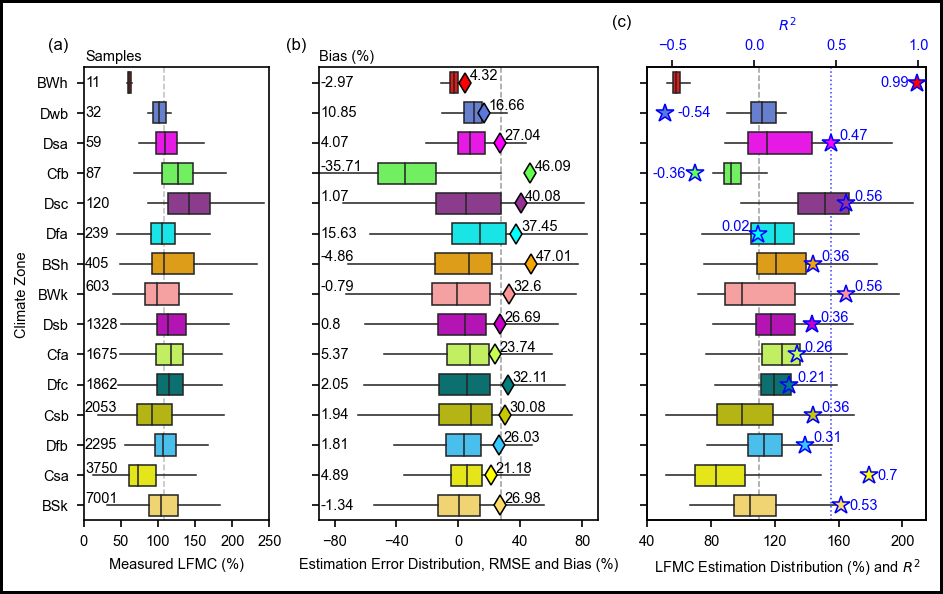

In [18]:
xlim_rmse = (-90, 90)
xlim_r2 = (-0.65, 1.05)
xlim_lfmc = (40, 215)

plt.rcParams.update({'font.sans-serif': 'Arial'})
plt.rcParams.update({'font.size': TEXT_SIZE})
fig, ((ax1, ax2, ax3)) = plt.subplots(
    1, 3, figsize=(7.25, 4), gridspec_kw={'width_ratios': [2, 3, 3]},
    sharey=True, sharex=False,
    constrained_layout=False, dpi=150, linewidth=2, edgecolor="black")

#ax1 = samples_plot(data_summ, plot_order, czones, ax=ax1)
ax1, ylim = samples_plot(data_summ, samples, plot_order, czones, ax=ax1)
ax1.text(-20, -1.5, '(a)', va='top', ha='right', size=TITLE_SIZE)
ax2 = results_plot(samples, predicts, data1, plot_order, czones, xlim=xlim_rmse,
                   xline=MODEL_RMSE, ylim=ylim, ax=ax2)
ax2.text(-98, -1.5, '(b)', va='top', ha='right', size=TITLE_SIZE)
ax3 = r2_plot(samples, predicts, data1, plot_order, czones, xlim_lfmc, xlim_r2,
              xline=MODEL_R2, ylim=ylim, ax=ax3)
ax3.text(30, -2, '(c)', va='center', ha='right', size=TITLE_SIZE)

plt.subplots_adjust(wspace=0.2)

fig.savefig(os.path.join(common.FIGURES_DIR, 'Climate zone results.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=600)